In [30]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

# Helper Functions

In [2]:
def reformat_allele(allele: str, resolution: int = 2) -> str:
    """
    Reformats an allele string to a standard format.
    For example, for two-field resolution:
      "A*01:03:XX" -> "A*01:03"
    For one-field resolution:
      "A*01:03" -> "A*01"
    """
    allele = allele.strip()
    if "*" not in allele:
        return allele
    gene, rest = allele.split("*", 1)
    fields = rest.split(":")
    if resolution == 1:
        return f"{gene}*{fields[0]}"
    elif resolution == 2:
        if len(fields) >= 2:
            return f"{gene}*{fields[0]}:{fields[1]}"
        else:
            return f"{gene}*{fields[0]}"
    else:
        return allele

def compare_allele_pair(gs_alleles: list, pre_alleles: list, resolution: int = 2) -> int:
    """
    Compares a pair of gold-standard alleles (list of two strings) 
    with a pair of predicted alleles.
    Returns the maximum number of matches (0, 1, or 2) by checking both 
    the parallel and cross comparisons.
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    pre_fmt = [reformat_allele(a, resolution) for a in pre_alleles]
    
    parallel = (gs_fmt[0] == pre_fmt[0]) + (gs_fmt[1] == pre_fmt[1])
    cross = (gs_fmt[0] == pre_fmt[1]) + (gs_fmt[1] == pre_fmt[0])
    return max(parallel, cross)

def compare_allele_pair_filtered(gs_alleles: list, pre_alleles: list, valid_flags: list, resolution: int = 2) -> int:
    """
    Like compare_allele_pair, but only counts a predicted allele if it is valid.
    valid_flags is a list of booleans (one per allele) indicating whether the corresponding
    predicted allele passes the valid-set filter.
    For invalid predictions, that allele is treated as a "no call" (i.e. contributes 0 to the match).
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    # For each predicted allele, only reformat it if it is valid; otherwise, set to None.
    pre_fmt = [reformat_allele(a, resolution) if valid else None for a, valid in zip(pre_alleles, valid_flags)]
    
    # For parallel comparison, count a match only if the predicted allele is valid.
    parallel = 0
    if pre_fmt[0] is not None and gs_fmt[0] == pre_fmt[0]:
        parallel += 1
    if pre_fmt[1] is not None and gs_fmt[1] == pre_fmt[1]:
        parallel += 1
    
    # Cross comparison.
    cross = 0
    if pre_fmt[1] is not None and gs_fmt[0] == pre_fmt[1]:
        cross += 1
    if pre_fmt[0] is not None and gs_fmt[1] == pre_fmt[0]:
        cross += 1
    return max(parallel, cross)





In [3]:
def get_dynamic_loci_from_gs(gs_df: pd.DataFrame) -> list:
    """
    Assumes the first column is a sample identifier.
    Every column after that corresponds to a locus.
    If a column name contains a '.1' suffix, it is removed.
    Returns a unique list of locus names.
    """
    loci = set()
    for col in gs_df.columns[1:]:
        # Remove any '.1' suffix
        locus = col.split('.')[0]
        loci.add(locus)
    return list(loci)

In [ ]:
def calculate_accuracy(gs_file: str, pre_file: str, resolution: int = 2, filter_option: bool = False):
    """
    Reads the gold standard and prediction CSV files and computes overall accuracy.
    
    Assumptions:
      - The gold-standard CSV (gs_file) has a "Run" column and columns for each locus.
        For each locus, there may be one column (e.g. "DRB1_gs") or two (e.g. "DRB1_gs" and "DRB1.1_gs").
      - The prediction CSV (pre_file) has an "ERR" column that matches the gold standard "Run" identifiers.
        For each locus, predictions are expected in a column named "{locus}_pre"; if a second prediction exists,
        it should be in a column named "{locus}.1_pre". If only one prediction is available for a diploid locus,
        it will be duplicated.
      
    filter_option: if True, only predicted alleles that appear in the gold-standard valid set (built from gs_file)
                   are counted in the accuracy calculation.
    
    Returns:
      A tuple (accuracy, total_correct, total_valid_calls, miscalled_alleles)
    """
    gs_df = pd.read_csv(gs_file)
    pre_df = pd.read_csv(pre_file)
    
    
    # Dynamically determine loci from the gold standard.
    loci = get_dynamic_loci_from_gs(gs_df)
    #print(loci)
    
    id_col_gs = gs_df.columns[0]
    id_col_pre = pre_df.columns[0]
    merged_df = pd.merge(gs_df, pre_df, left_on=id_col_gs, right_on=id_col_pre, suffixes=("_gs", "_pre"))
    #print(merged_df)
    total_correct = 0
    total_calls = 0
    miscalled_alleles = []
    
    # Build valid allele sets for filtering if enabled.
    valid_set = {}
    if filter_option:
        valid_set = {locus: set() for locus in loci}
        for _, row in gs_df.iterrows():
            for col in gs_df.columns[1:]:
                locus = col.split('.')[0]
                if locus in loci:
                    gs_val = row[col]
                    if pd.isna(gs_val):
                        continue
                    for allele in str(gs_val).split("/"):
                        valid_set[locus].add(reformat_allele(allele.strip(), resolution))
    
    for _, row in merged_df.iterrows():
        #print(row)
        for locus in loci:
            # Retrieve gold-standard alleles from all GS columns for this locus.
            gs_alleles_raw = []
            col1 = f"{locus}_gs"
            col2 = f"{locus}.1_gs"
            if col1 in row and not pd.isna(row[col1]):
                gs_alleles_raw.extend([a.strip() for a in str(row[col1]).split("/")])
            if col2 in row and not pd.isna(row[col2]):
                gs_alleles_raw.extend([a.strip() for a in str(row[col2]).split("/")])
            if not gs_alleles_raw:
                continue
            #print(gs_alleles_raw)
            # Form the union of all reformatted alleles.
            gs_allele_set = set(reformat_allele(a, resolution) for a in gs_alleles_raw)
            #print(gs_allele_set)
            # Decide mode: if more than two distinct alleles exist, use ambiguous mode.
            use_ambiguous = len(gs_allele_set) > 2
            
            # If not ambiguous, if the set has only one allele, duplicate it; if two, convert to list.
            if not use_ambiguous:
                gs_alleles = list(gs_allele_set)
                if len(gs_alleles) == 1:
                    gs_alleles = [gs_alleles[0], gs_alleles[0]]
            # Otherwise, in ambiguous mode, we simply use the full set.
            
            # Retrieve predicted alleles.
            pre_alleles = []
            pre_col1 = f"{locus}_pre"
            pre_col2 = f"{locus}.1_pre"
            if pre_col1 in row and not pd.isna(row[pre_col1]):
                pre_alleles.extend([a.strip() for a in str(row[pre_col1]).split("/")])
            if pre_col2 in row and not pd.isna(row[pre_col2]):
                pre_alleles.extend([a.strip() for a in str(row[pre_col2]).split("/")])
            if not pre_alleles:
                continue
            # If only one prediction is provided, duplicate it; if more than two, take first two.
            if len(pre_alleles) == 1:
                pre_alleles = [pre_alleles[0], pre_alleles[0]]
            elif len(pre_alleles) > 2:
                pre_alleles = pre_alleles[:2]
            if len(pre_alleles) != 2:
                continue
            
            # Compare predicted alleles to gold standard.
            if use_ambiguous:
                # In ambiguous mode, count each predicted allele as correct if it appears in the full GS set.
                pred1 = reformat_allele(pre_alleles[0], resolution)
                pred2 = reformat_allele(pre_alleles[1], resolution)
                match_count = (1 if pred1 in gs_allele_set else 0) + (1 if pred2 in gs_allele_set else 0)
            else:
                match_count = compare_allele_pair(gs_alleles, pre_alleles, resolution)
            
            if filter_option:
                valid_flags = []
                for allele in pre_alleles:
                    allele_fmt = reformat_allele(allele, resolution)
                    valid_flags.append(allele_fmt in valid_set.get(locus, set()))
                valid_call_count = sum(valid_flags)
                total_calls += valid_call_count
                if not use_ambiguous:
                    match_count = compare_allele_pair_filtered(gs_alleles, pre_alleles, valid_flags, resolution)
                total_correct += match_count
                if match_count < valid_call_count:
                    miscalled_alleles.extend(list(gs_allele_set))
            else:
                total_correct += match_count
                total_calls += 2
                if match_count < 2:
                    miscalled_alleles.extend(list(gs_allele_set))
    
    accuracy = total_correct / total_calls if total_calls > 0 else 0
    return accuracy, total_correct, total_calls, miscalled_alleles

In [5]:
gs_file = "../datasets/1_gs.csv"       # Path to gold standard file.
pre_file = "../results/standard/arcas_d1.csv"  # Path to tool prediction file.

# Calculate accuracy without filtering.
calculate_accuracy(gs_file, pre_file, resolution=2, filter_option=False)


(0.9371428571428572,
 4592,
 4900,
 ['DQB1*03:24',
  'DQB1*03:09',
  'DQB1*03:22',
  'DQB1*03:21',
  'DQB1*03:19',
  'DQB1*03:01',
  'B*2',
  'B*1900 9:01',
  'B*41:02',
  'B*1',
  'A*02:01',
  'A*02:75',
  'A*32:01',
  'A*02:43',
  'A*02:14',
  'A*02:89',
  'A*02:97',
  'A*02:66',
  'A*02:13',
  'A*02:09',
  'A*02:83',
  'A*03:45',
  'A*11:01',
  'A*03:37',
  'A*03:20',
  'A*03:26',
  'A*11:21',
  'A*03:01',
  'A*03:21',
  'A*11:01',
  'A*01:01',
  'A*01:04',
  'A*01:37',
  'A*01:32',
  'A*01:22',
  'A*11:21',
  'A*01:34',
  'DQB1*02:01',
  'DQB1*02:04',
  'DQB1*02:02',
  'DQB1*02:01',
  'C*08:02',
  'C*07:01',
  'C*03:03',
  'C*03:20',
  'C*02:02',
  'B*27:05',
  'B*27:13',
  'DQB1*06:05',
  'DQB1*03:01',
  'B*27:03',
  'B*07:02',
  'B*27:52',
  'B*27:09',
  'DQB1*03:24',
  'DQB1*03:09',
  'DQB1*03:22',
  'DQB1*03:21',
  'DQB1*03:19',
  'DQB1*03:01',
  'DQB1*02:01',
  'DQB1*03:01',
  'DQB1*06:02',
  'DQB1*03:01',
  'A*25:01',
  'A*11:01',
  'A*02:01',
  'A*02:75',
  'A*11:01',
  'A*0

In [6]:

gs_file = "../datasets/1_gs.csv"       # Path to gold standard file.
pre_file = "../results/standard/arcas_d1.csv"  # Path to tool prediction file.

# Calculate accuracy without filtering.
accuracy, correct, calls, miscalled = calculate_accuracy(gs_file, pre_file, resolution=2, filter_option=False)
print("Without filtering:")
print(f"Overall two-field accuracy: {accuracy:.3f}")
print(f"Total correct calls: {correct} / {calls}")
print(f"Number of miscalled alleles: {len(miscalled)}")

#Calculate accuracy with filtering enabled.
accuracy_filt, correct_filt, calls_filt, miscalled_filt = calculate_accuracy(gs_file, pre_file, resolution=2, filter_option=True)
print("\nWith filtering:")
print(f"Overall two-field accuracy: {accuracy_filt:.3f}")
print(f"Total correct calls: {correct_filt} / {calls_filt}")
print(f"Number of miscalled alleles: {len(miscalled_filt)}")


Without filtering:
Overall two-field accuracy: 0.937
Total correct calls: 4592 / 4900
Number of miscalled alleles: 1052

With filtering:
Overall two-field accuracy: 0.970
Total correct calls: 4592 / 4732
Number of miscalled alleles: 239


In [11]:
import pandas as pd

def reformat_allele(allele: str, resolution: int = 2) -> str:
    """
    Reformats an allele string to a standard format.
    For example, for two-field resolution:
      "A*01:03:XX" -> "A*01:03"
    For one-field resolution:
      "A*01:03" -> "A*01"
    """
    allele = allele.strip()
    if "*" not in allele:
        return allele
    gene, rest = allele.split("*", 1)
    fields = rest.split(":")
    if resolution == 1:
        return f"{gene}*{fields[0]}"
    elif resolution == 2:
        if len(fields) >= 2:
            return f"{gene}*{fields[0]}:{fields[1]}"
        else:
            return f"{gene}*{fields[0]}"
    else:
        return allele

def compare_allele_pair(gs_alleles: list, pre_alleles: list, resolution: int = 2) -> int:
    """
    Compares a pair of gold-standard alleles (list of two strings) 
    with a pair of predicted alleles.
    Returns the maximum number of matches (0, 1, or 2) by checking both 
    the parallel and cross comparisons.
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    pre_fmt = [reformat_allele(a, resolution) for a in pre_alleles]
    
    parallel = (gs_fmt[0] == pre_fmt[0]) + (gs_fmt[1] == pre_fmt[1])
    cross = (gs_fmt[0] == pre_fmt[1]) + (gs_fmt[1] == pre_fmt[0])
    return max(parallel, cross)

def compare_allele_pair_filtered(gs_alleles: list, pre_alleles: list, valid_flags: list, resolution: int = 2) -> int:
    """
    Like compare_allele_pair, but only counts a predicted allele if it is valid.
    valid_flags is a list of booleans (one per allele) indicating whether the corresponding
    predicted allele passes the valid-set filter.
    For invalid predictions, that allele is treated as a "no call" (i.e. contributes 0 to the match).
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    # For each predicted allele, only reformat it if it is valid; otherwise, set to None.
    pre_fmt = [reformat_allele(a, resolution) if valid else None for a, valid in zip(pre_alleles, valid_flags)]
    
    # For parallel comparison, count a match only if the predicted allele is valid.
    parallel = 0
    if pre_fmt[0] is not None and gs_fmt[0] == pre_fmt[0]:
        parallel += 1
    if pre_fmt[1] is not None and gs_fmt[1] == pre_fmt[1]:
        parallel += 1
    
    # Cross comparison.
    cross = 0
    if pre_fmt[1] is not None and gs_fmt[0] == pre_fmt[1]:
        cross += 1
    if pre_fmt[0] is not None and gs_fmt[1] == pre_fmt[0]:
        cross += 1
    return max(parallel, cross)

def get_dynamic_loci_from_gs(gs_df: pd.DataFrame) -> list:
    """
    Assumes the first column is a sample identifier.
    Every column after that corresponds to a locus.
    If a column name contains a '.1' suffix, it is removed.
    Returns a unique list of locus names.
    """
    loci = set()
    for col in gs_df.columns[1:]:
        # Remove any '.1' suffix
        locus = col.split('.')[0]
        loci.add(locus)
    return list(loci)

def calculate_accuracy(gs_file: str, pre_file: str, resolution: int = 2, filter_option: bool = False):
    """
    Reads the gold standard and prediction CSV files and computes overall accuracy,
    now including a no-calls category.

    Assumptions:
      - The gold-standard CSV (gs_file) has a "Run" column and columns for each locus.
        For each locus, there may be one column (e.g. "DRB1_gs") or two (e.g. "DRB1_gs" and "DRB1.1_gs").
      - The prediction CSV (pre_file) has an "ERR" column that matches the gold standard "Run" identifiers.
        For each locus, predictions are expected in a column named "{locus}_pre"; if a second prediction exists,
        it should be in a column named "{locus}.1_pre". If only one prediction is available for a diploid locus,
        it will be duplicated.
      
    filter_option: if True, only predicted alleles that appear in the gold-standard valid set (built from gs_file)
                   are counted in the accuracy calculation.
    
    Returns:
      A tuple:
        accuracy,            # (total_correct / total_calls)
        total_correct,       # number of matched alleles
        total_calls,         # total diploid calls (2 per locus that has gold-standard data)
        no_calls,            # how many alleles were not called at all
        miscalled_alleles    # list of gold-standard alleles that were miscalled
    """
    gs_df = pd.read_csv(gs_file)
    pre_df = pd.read_csv(pre_file)
    
    # Dynamically determine loci from the gold standard.
    loci = get_dynamic_loci_from_gs(gs_df)
    
    id_col_gs = gs_df.columns[0]
    id_col_pre = pre_df.columns[0]
    merged_df = pd.merge(gs_df, pre_df, left_on=id_col_gs, right_on=id_col_pre, suffixes=("_gs", "_pre"))
    
    total_correct = 0
    total_calls = 0
    no_calls = 0
    miscalled_alleles = []
    
    # Build valid allele sets for filtering if enabled.
    valid_set = {}
    if filter_option:
        valid_set = {locus: set() for locus in loci}
        for _, row in gs_df.iterrows():
            for col in gs_df.columns[1:]:
                locus = col.split('.')[0]
                if locus in loci:
                    gs_val = row[col]
                    if pd.isna(gs_val):
                        continue
                    for allele in str(gs_val).split("/"):
                        valid_set[locus].add(reformat_allele(allele.strip(), resolution))
    
    for _, row in merged_df.iterrows():
        for locus in loci:
            # Retrieve gold-standard alleles from all GS columns for this locus.
            gs_alleles_raw = []
            col1 = f"{locus}_gs"
            col2 = f"{locus}.1_gs"
            if col1 in row and not pd.isna(row[col1]):
                gs_alleles_raw.extend([a.strip() for a in str(row[col1]).split("/")])
            if col2 in row and not pd.isna(row[col2]):
                gs_alleles_raw.extend([a.strip() for a in str(row[col2]).split("/")])
            if not gs_alleles_raw:
                # No gold-standard allele => skip this locus entirely
                continue

            # Each locus is diploid => 2 calls
            total_calls += 2

            # Reformat the gold-standard alleles to a set
            gs_allele_set = set(reformat_allele(a, resolution) for a in gs_alleles_raw)
            # If more than two distinct alleles => ambiguous mode
            use_ambiguous = len(gs_allele_set) > 2

            if not use_ambiguous:
                gs_alleles = list(gs_allele_set)
                if len(gs_alleles) == 1:
                    # If there's only one distinct allele in the set, duplicate it
                    gs_alleles = [gs_alleles[0], gs_alleles[0]]
            
            # Gather predicted alleles
            pre_alleles = []
            pre_col1 = f"{locus}_pre"
            pre_col2 = f"{locus}.1_pre"
            if pre_col1 in row and not pd.isna(row[pre_col1]):
                pre_alleles.extend([a.strip() for a in str(row[pre_col1]).split("/")])
            if pre_col2 in row and not pd.isna(row[pre_col2]):
                pre_alleles.extend([a.strip() for a in str(row[pre_col2]).split("/")])
            
            # ---------------------
            # No-calls logic
            # ---------------------
            if len(pre_alleles) == 0:
                # No predicted alleles => 2 no-calls
                no_calls += 2
                # All miscalled
                miscalled_alleles.extend(gs_allele_set)
                continue
            elif len(pre_alleles) == 1:
                # If only one predicted allele => 1 no-call
                no_calls += 1
                # Duplicate the single allele for pairwise comparison
                pre_alleles = [pre_alleles[0], pre_alleles[0]]
            elif len(pre_alleles) > 2:
                # If more than two, keep only first two
                pre_alleles = pre_alleles[:2]
            
            if len(pre_alleles) != 2:
                # If we still don't have two predicted alleles, skip
                # (though the logic above should produce 2 if there's at least 1)
                miscalled_alleles.extend(gs_allele_set)
                continue
            
            # Compare predicted alleles to gold standard
            if use_ambiguous:
                # In ambiguous mode, each predicted allele is correct if it appears in gs_allele_set
                pred1 = reformat_allele(pre_alleles[0], resolution)
                pred2 = reformat_allele(pre_alleles[1], resolution)
                match_count = (1 if pred1 in gs_allele_set else 0) + (1 if pred2 in gs_allele_set else 0)
            else:
                match_count = compare_allele_pair(gs_alleles, pre_alleles, resolution)
            
            if filter_option:
                # Evaluate valid_flags
                valid_flags = []
                for allele in pre_alleles:
                    allele_fmt = reformat_allele(allele, resolution)
                    valid_flags.append(allele_fmt in valid_set[locus])
                
                valid_call_count = sum(valid_flags)
                
                # Overwrite the "match_count" with the filtered version if not ambiguous
                if not use_ambiguous:
                    match_count = compare_allele_pair_filtered(gs_alleles, pre_alleles, valid_flags, resolution)
                
                # total_calls was already incremented by 2 above
                # We'll only count valid predictions in the denominator if you prefer:
                # But typically we keep the 2 calls for diploid logic.
                
                total_correct += match_count
                if match_count < valid_call_count:
                    miscalled_alleles.extend(gs_allele_set)
            else:
                total_correct += match_count
                # We keep total_calls at 2
                if match_count < 2:
                    miscalled_alleles.extend(gs_allele_set)
    
    accuracy = total_correct / total_calls if total_calls > 0 else 0
    return accuracy, total_correct, total_calls, no_calls, miscalled_alleles


# Accuracy by Dataset

In [14]:
import pandas as pd

# List of tool names that you want to evaluate.
tools = ["arcas", "optitype", "seq2hla", "hlaminer", "phlat", "hlavbseq", "hlahd"]
# Dataset numbers to iterate over.
dataset_nums = range(1, 9)

# List to store results.
results = []

# Loop over each tool and each dataset.
for tool in tools:
    for ds in dataset_nums:
        gs_file = f"../datasets/{ds}_gs.csv"          # Gold standard file for dataset ds.
        pre_file = f"../results/standard/{tool}_d{ds}.csv"  # Prediction file for the tool on dataset ds.
        try:
            # Call the updated accuracy function, which returns (accuracy, total_correct, total_calls, no_calls, miscalled_alleles).
            accuracy, correct, calls, no_calls, miscalled = calculate_accuracy(
                gs_file,
                pre_file,
                resolution=2,
                filter_option=False
            )
            # Append the results to our list
            results.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy,
                "CorrectCalls": correct,
                "TotalCalls": calls,
                "NoCalls": no_calls,
                "NumMiscalled": len(miscalled)
            })
            print(f"Processed {tool} on dataset {ds}: Accuracy = {accuracy:.3f}")
        except Exception as e:
            print(f"Error processing {tool} on dataset {ds}: {e}")

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)
print("\nSummary of Accuracy Evaluations:")
print(df_results)

# Optionally, save to a CSV file
# df_results.to_csv("accuracy_summary.csv", index=False)


Processed arcas on dataset 1: Accuracy = 0.937
Processed arcas on dataset 2: Accuracy = 0.948
Processed arcas on dataset 3: Accuracy = 0.677
Processed arcas on dataset 4: Accuracy = 0.143
Processed arcas on dataset 5: Accuracy = 1.000
Processed arcas on dataset 6: Accuracy = 1.000
Processed arcas on dataset 7: Accuracy = 0.150
Error processing arcas on dataset 8: [Errno 2] No such file or directory: '../results/standard/arcas_d8.csv'
Processed optitype on dataset 1: Accuracy = 0.982
Processed optitype on dataset 2: Accuracy = 0.000
Processed optitype on dataset 3: Accuracy = 0.940
Processed optitype on dataset 4: Accuracy = 0.000
Processed optitype on dataset 5: Accuracy = 0.625
Processed optitype on dataset 6: Accuracy = 1.000
Processed optitype on dataset 7: Accuracy = 0.263
Error processing optitype on dataset 8: [Errno 2] No such file or directory: '../results/standard/optitype_d8.csv'
Processed seq2hla on dataset 1: Accuracy = 0.920
Processed seq2hla on dataset 2: Accuracy = 0.292

# Bulk Accuracy

In [15]:
import pandas as pd

# List of tool names that you want to evaluate.
tools = ["arcas", "optitype", "seq2hla", "hlaminer", "phlat", "hla_vbseq", "hlahd", "hisat_genotype"]
# Dataset numbers to iterate over.
dataset_nums = range(1, 9)

# Lists to store per-dataset results for each resolution/filter combination.
results_2field = []
results_1field = []
results_2field_filtered = []
results_1field_filtered = []

# Loop over each tool and each dataset.
for tool in tools:
    for ds in dataset_nums:
        gs_file = f"../datasets/{ds}_gs.csv"          # Gold standard file for dataset ds.
        pre_file = f"../results/standard/{tool}_d{ds}.csv"  # Prediction file for the tool on dataset ds.
        try:
            # Call the updated accuracy function, returning:
            # (accuracy, total_correct, total_calls, no_calls, miscalled_alleles).
            accuracy_2field, correct_2field, calls_2field, no_calls_2field, miscalled_2field = calculate_accuracy(
                gs_file, pre_file, resolution=2, filter_option=False
            )
            accuracy_1field, correct_1field, calls_1field, no_calls_1field, miscalled_1field = calculate_accuracy(
                gs_file, pre_file, resolution=1, filter_option=False
            )
            accuracy_2field_filt, correct_2field_filt, calls_2field_filt, no_calls_2field_filt, miscalled_2field_filt = calculate_accuracy(
                gs_file, pre_file, resolution=2, filter_option=True
            )
            accuracy_1field_filt, correct_1field_filt, calls_1field_filt, no_calls_1field_filt, miscalled_1field_filt = calculate_accuracy(
                gs_file, pre_file, resolution=1, filter_option=True
            )

            # Store the results for 2-field (unfiltered)
            results_2field.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_2field,
                "CorrectCalls": correct_2field,
                "TotalCalls": calls_2field,
                "NoCalls": no_calls_2field,
                "NumMiscalled": len(miscalled_2field)
            })

            # Store the results for 1-field (unfiltered)
            results_1field.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_1field,
                "CorrectCalls": correct_1field,
                "TotalCalls": calls_1field,
                "NoCalls": no_calls_1field,
                "NumMiscalled": len(miscalled_1field)
            })

            # Store the results for 2-field (filtered)
            results_2field_filtered.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_2field_filt,
                "CorrectCalls": correct_2field_filt,
                "TotalCalls": calls_2field_filt,
                "NoCalls": no_calls_2field_filt,
                "NumMiscalled": len(miscalled_2field_filt)
            })

            # Store the results for 1-field (filtered)
            results_1field_filtered.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_1field_filt,
                "CorrectCalls": correct_1field_filt,
                "TotalCalls": calls_1field_filt,
                "NoCalls": no_calls_1field_filt,
                "NumMiscalled": len(miscalled_1field_filt)
            })

            # Print summary for each run
            print(f"Processed {tool} on dataset {ds} - 2field: {accuracy_2field:.3f}, 1field: {accuracy_1field:.3f}, "
                  f"2field_filt: {accuracy_2field_filt:.3f}, 1field_filt: {accuracy_1field_filt:.3f}")

        except Exception as e:
            print(f"Error processing {tool} on dataset {ds}: {e}")

# Convert per-dataset results to DataFrames.
df_2field = pd.DataFrame(results_2field)
df_1field = pd.DataFrame(results_1field)
df_2field_filt = pd.DataFrame(results_2field_filtered)
df_1field_filt = pd.DataFrame(results_1field_filtered)

print("\nPer-dataset Accuracy Evaluations (2-field, unfiltered):")
print(df_2field.head())
print("\nPer-dataset Accuracy Evaluations (1-field, unfiltered):")
print(df_1field.head())
# ... etc.

# Now, group the results by tool to compute bulk accuracy for each scenario.
# We sum CorrectCalls, TotalCalls, and NoCalls. Then we compute BulkAccuracy = CorrectCalls / TotalCalls.
# Optionally, compute a NoCallRate = NoCalls / TotalCalls.

def compute_bulk_accuracy(df):
    grouped = df.groupby("Tool").agg({
        "CorrectCalls": "sum",
        "TotalCalls": "sum",
        "NoCalls": "sum"
    }).reset_index()
    grouped["BulkAccuracy"] = grouped["CorrectCalls"] / grouped["TotalCalls"]
    grouped["NoCallRate"] = grouped["NoCalls"] / grouped["TotalCalls"]
    # Convert to percentages if you want
    grouped["BulkAccuracy%"] = grouped["BulkAccuracy"] * 100
    grouped["NoCallRate%"] = grouped["NoCallRate"] * 100
    return grouped

bulk_2field = compute_bulk_accuracy(df_2field)
bulk_1field = compute_bulk_accuracy(df_1field)
bulk_2field_filt = compute_bulk_accuracy(df_2field_filt)
bulk_1field_filt = compute_bulk_accuracy(df_1field_filt)

print("\nBulk Accuracy (2-field, unfiltered):")
print(bulk_2field)
print("\nBulk Accuracy (1-field, unfiltered):")
print(bulk_1field)
print("\nBulk Accuracy (2-field, filtered):")
print(bulk_2field_filt)
print("\nBulk Accuracy (1-field, filtered):")
print(bulk_1field_filt)

# Optionally, save results to CSV files:
# df_2field.to_csv("results_2field.csv", index=False)
# bulk_2field.to_csv("bulk_2field.csv", index=False)



Processed arcas on dataset 1 - 2field: 0.937, 1field: 0.991, 2field_filt: 0.937, 1field_filt: 0.991
Processed arcas on dataset 2 - 2field: 0.948, 1field: 0.977, 2field_filt: 0.948, 1field_filt: 0.977
Processed arcas on dataset 3 - 2field: 0.677, 1field: 0.970, 2field_filt: 0.677, 1field_filt: 0.970
Processed arcas on dataset 4 - 2field: 0.143, 1field: 0.143, 2field_filt: 0.143, 1field_filt: 0.143
Processed arcas on dataset 5 - 2field: 1.000, 1field: 1.000, 2field_filt: 1.000, 1field_filt: 1.000
Processed arcas on dataset 6 - 2field: 1.000, 1field: 1.000, 2field_filt: 1.000, 1field_filt: 1.000
Processed arcas on dataset 7 - 2field: 0.150, 1field: 0.295, 2field_filt: 0.150, 1field_filt: 0.295
Error processing arcas on dataset 8: [Errno 2] No such file or directory: '../results/standard/arcas_d8.csv'
Processed optitype on dataset 1 - 2field: 0.982, 1field: 0.997, 2field_filt: 0.982, 1field_filt: 0.997
Processed optitype on dataset 2 - 2field: 0.000, 1field: 0.000, 2field_filt: 0.000, 1fie

In [16]:
results_2field

[{'Tool': 'arcas',
  'Dataset': 1,
  'Accuracy': 0.9371428571428572,
  'CorrectCalls': 4592,
  'TotalCalls': 4900,
  'NoCalls': 0,
  'NumMiscalled': 1052},
 {'Tool': 'arcas',
  'Dataset': 2,
  'Accuracy': 0.9476744186046512,
  'CorrectCalls': 163,
  'TotalCalls': 172,
  'NoCalls': 0,
  'NumMiscalled': 18},
 {'Tool': 'arcas',
  'Dataset': 3,
  'Accuracy': 0.6766666666666666,
  'CorrectCalls': 203,
  'TotalCalls': 300,
  'NoCalls': 0,
  'NumMiscalled': 143},
 {'Tool': 'arcas',
  'Dataset': 4,
  'Accuracy': 0.14285714285714285,
  'CorrectCalls': 4,
  'TotalCalls': 28,
  'NoCalls': 24,
  'NumMiscalled': 24},
 {'Tool': 'arcas',
  'Dataset': 5,
  'Accuracy': 1.0,
  'CorrectCalls': 16,
  'TotalCalls': 16,
  'NoCalls': 8,
  'NumMiscalled': 0},
 {'Tool': 'arcas',
  'Dataset': 6,
  'Accuracy': 1.0,
  'CorrectCalls': 8,
  'TotalCalls': 8,
  'NoCalls': 4,
  'NumMiscalled': 0},
 {'Tool': 'arcas',
  'Dataset': 7,
  'Accuracy': 0.15,
  'CorrectCalls': 30,
  'TotalCalls': 200,
  'NoCalls': 104,
  'Num

In [17]:
results_1field

[{'Tool': 'arcas',
  'Dataset': 1,
  'Accuracy': 0.9910204081632653,
  'CorrectCalls': 4856,
  'TotalCalls': 4900,
  'NoCalls': 0,
  'NumMiscalled': 80},
 {'Tool': 'arcas',
  'Dataset': 2,
  'Accuracy': 0.9767441860465116,
  'CorrectCalls': 168,
  'TotalCalls': 172,
  'NoCalls': 0,
  'NumMiscalled': 8},
 {'Tool': 'arcas',
  'Dataset': 3,
  'Accuracy': 0.97,
  'CorrectCalls': 291,
  'TotalCalls': 300,
  'NoCalls': 0,
  'NumMiscalled': 15},
 {'Tool': 'arcas',
  'Dataset': 4,
  'Accuracy': 0.14285714285714285,
  'CorrectCalls': 4,
  'TotalCalls': 28,
  'NoCalls': 24,
  'NumMiscalled': 24},
 {'Tool': 'arcas',
  'Dataset': 5,
  'Accuracy': 1.0,
  'CorrectCalls': 16,
  'TotalCalls': 16,
  'NoCalls': 8,
  'NumMiscalled': 0},
 {'Tool': 'arcas',
  'Dataset': 6,
  'Accuracy': 1.0,
  'CorrectCalls': 8,
  'TotalCalls': 8,
  'NoCalls': 4,
  'NumMiscalled': 0},
 {'Tool': 'arcas',
  'Dataset': 7,
  'Accuracy': 0.295,
  'CorrectCalls': 59,
  'TotalCalls': 200,
  'NoCalls': 104,
  'NumMiscalled': 170},

In [18]:
results_1field['type']='pre-filter'
results_1field_filtered['type']='filtered'
field_1_df=pd.concat([results_1field,results_1field_filtered])

results_2field['type']='pre-filter'
results_2field_filtered['type']='filtered'
field_2_df=pd.concat([results_1field,results_1field_filtered])


TypeError: list indices must be integers or slices, not str

In [125]:
field_2_df

,Tool,CorrectCalls,TotalCalls,BulkAccuracy,BulkAccuracy%,type
0,arcas,5402,5496,0.982897,98.289665,pre-filter
1,hlaminer,1343,5374,0.249907,24.990696,pre-filter
2,optitype,3275,3348,0.978196,97.819594,pre-filter
3,phlat,4894,5410,0.904621,90.462107,pre-filter
4,seq2HLA,5181,5420,0.955904,95.590406,pre-filter
0,arcas,5402,5495,0.912830,96.610169,filtered
1,hlaminer,1343,5223,0.083668,18.028053,filtered
2,optitype,3275,3336,0.964329,97.307925,filtered
3,phlat,4894,5399,0.826820,88.099467,filtered
4,seq2HLA,5181,5405,0.883996,95.027844,filtered


## bulk accuracy by class

Error processing arcas on dataset 8: [Errno 2] No such file or directory: '../results/standard/arcas_d8.csv'
Error processing optitype on dataset 8: [Errno 2] No such file or directory: '../results/standard/optitype_d8.csv'
Error processing seq2hla on dataset 7: [Errno 2] No such file or directory: '../results/standard/seq2hla_d7.csv'
Error processing seq2hla on dataset 8: [Errno 2] No such file or directory: '../results/standard/seq2hla_d8.csv'
Error processing hlaminer on dataset 8: [Errno 2] No such file or directory: '../results/standard/hlaminer_d8.csv'
Error processing phlat on dataset 7: [Errno 2] No such file or directory: '../results/standard/phlat_d7.csv'
Error processing phlat on dataset 8: [Errno 2] No such file or directory: '../results/standard/phlat_d8.csv'
Error processing hlavbseq on dataset 8: [Errno 2] No such file or directory: '../results/standard/hlavbseq_d8.csv'
Error processing hlahd on dataset 7: [Errno 2] No such file or directory: '../results/standard/hlahd_d

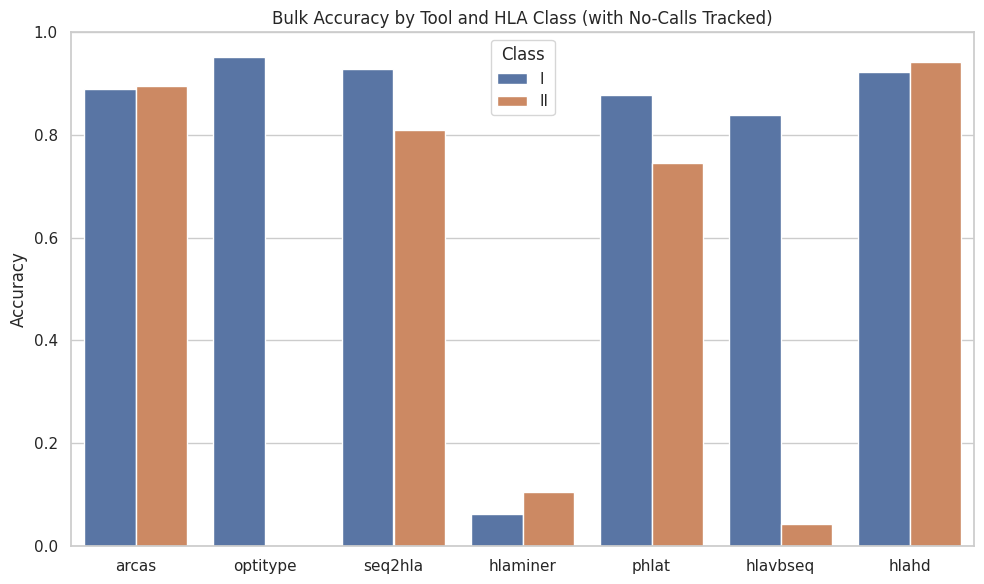

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# 1) Define the helper logic
# --------------------------

classI_loci = {"A", "B", "C"}
classII_loci = {"DRB1", "DQB1"}

def reformat_allele(allele: str, resolution: int = 2) -> str:
    """
    Reformats an allele string to a standard format.
    For two-field resolution:
      "A*01:03:XX" -> "A*01:03"
    For one-field resolution:
      "A*01:03" -> "A*01"
    """
    allele = allele.strip()
    if "*" not in allele:
        return allele
    gene, rest = allele.split("*", 1)
    fields = rest.split(":")
    if resolution == 1:
        return f"{gene}*{fields[0]}"
    elif resolution == 2:
        if len(fields) >= 2:
            return f"{gene}*{fields[0]}:{fields[1]}"
        else:
            return f"{gene}*{fields[0]}"
    else:
        return allele

def compare_allele_pair(gs_alleles: list, pre_alleles: list, resolution: int = 2) -> int:
    """
    Standard pairwise comparison of a pair of gold-standard alleles (gs_alleles)
    with a pair of predicted alleles (pre_alleles).
    Returns the maximum number of matches (0, 1, or 2) by comparing both parallel and cross.
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    pre_fmt = [reformat_allele(a, resolution) for a in pre_alleles]
    parallel = (gs_fmt[0] == pre_fmt[0]) + (gs_fmt[1] == pre_fmt[1])
    cross = (gs_fmt[0] == pre_fmt[1]) + (gs_fmt[1] == pre_fmt[0])
    return max(parallel, cross)

def get_dynamic_loci_from_gs(gs_df: pd.DataFrame) -> list:
    """
    Assumes the first column of gs_df is the sample identifier.
    Every column after that corresponds to a locus. If a column name contains a ".1" suffix,
    it is removed. Returns a unique list of locus names.
    """
    loci = set()
    for col in gs_df.columns[1:]:
        locus = col.split('.')[0]
        loci.add(locus)
    return list(loci)

# --------------------------------------
# 2) Main Bulk Accuracy Script with No-Calls
# --------------------------------------

# Tools and datasets to evaluate
tools = ["arcas", "optitype", "seq2hla", "hlaminer", "phlat", "hlavbseq", "hlahd"]
dataset_nums = range(1, 9)

# We'll track for each tool, and each class (I or II):
#   correct: number of correct calls
#   calls: total diploid calls
#   no_calls: number of no-called alleles
tool_counts = {
    tool: {
        "I": {"correct": 0, "calls": 0, "no_calls": 0},
        "II": {"correct": 0, "calls": 0, "no_calls": 0}
    }
    for tool in tools
}

resolution = 2  # two-field accuracy (adjust as needed)

def is_no_call(allele_str: str) -> bool:
    """
    Simple check for no-call. You can expand this logic if needed.
    """
    if not allele_str or pd.isna(allele_str):
        return True
    stripped = allele_str.strip().lower()
    return (stripped == "" or stripped == "." or stripped == "nan")

for tool in tools:
    for ds in dataset_nums:
        gs_file = f"../datasets/{ds}_gs.csv"          
        pre_file = f"../results/standard/{tool}_d{ds}.csv"
        try:
            gs_df = pd.read_csv(gs_file)
            pre_df = pd.read_csv(pre_file)
            
            # Gather dynamic loci from the gold-standard
            loci = get_dynamic_loci_from_gs(gs_df)
            
            # Merge on sample identifier (gold standard's first column, "ERR" in pre_df)
            id_col_gs = gs_df.columns[0]
            merged_df = pd.merge(gs_df, pre_df, left_on=id_col_gs, right_on="ERR", suffixes=("_gs", "_pre"))
            
            # Process each row (sample)
            for _, row in merged_df.iterrows():
                for locus in loci:
                    # Determine if locus is Class I or Class II
                    if locus in classI_loci:
                        cls = "I"
                    elif locus in classII_loci:
                        cls = "II"
                    else:
                        continue  # skip if not in either set

                    # Retrieve gold-standard alleles from columns
                    gs_alleles_raw = []
                    col1 = f"{locus}_gs"
                    col2 = f"{locus}.1_gs"
                    if col1 in row and not pd.isna(row[col1]):
                        gs_alleles_raw.extend(a.strip() for a in str(row[col1]).split("/"))
                    if col2 in row and not pd.isna(row[col2]):
                        gs_alleles_raw.extend(a.strip() for a in str(row[col2]).split("/"))
                    
                    if not gs_alleles_raw:
                        # no gold-standard allele => skip
                        continue
                    
                    # Each locus is diploid => +2 calls
                    tool_counts[tool][cls]["calls"] += 2

                    # Reformat gold-standard alleles
                    gs_allele_set = set(reformat_allele(a, resolution) for a in gs_alleles_raw)
                    use_ambiguous = (len(gs_allele_set) > 2)
                    if not use_ambiguous:
                        gs_list = list(gs_allele_set)
                        if len(gs_list) == 1:
                            gs_list = [gs_list[0], gs_list[0]]
                    
                    # Retrieve predicted alleles
                    pre_alleles = []
                    pre_col1 = f"{locus}_pre"
                    pre_col2 = f"{locus}.1_pre"
                    if pre_col1 in row and not pd.isna(row[pre_col1]):
                        pre_alleles.extend(a.strip() for a in str(row[pre_col1]).split("/"))
                    if pre_col2 in row and not pd.isna(row[pre_col2]):
                        pre_alleles.extend(a.strip() for a in str(row[pre_col2]).split("/"))
                    
                    # No predicted => 2 no-calls
                    if len(pre_alleles) == 0:
                        tool_counts[tool][cls]["no_calls"] += 2
                        # all miscalled => no correct calls
                        continue

                    # If only one predicted => partial no-call
                    if len(pre_alleles) == 1:
                        tool_counts[tool][cls]["no_calls"] += 1
                        # duplicate for pairwise
                        pre_alleles = [pre_alleles[0], pre_alleles[0]]
                    elif len(pre_alleles) > 2:
                        pre_alleles = pre_alleles[:2]
                    
                    if len(pre_alleles) != 2:
                        # still invalid => skip
                        continue

                    # Possibly check for partial no-calls if any is "." or empty
                    # For example:
                    for i in range(2):
                        if is_no_call(pre_alleles[i]):
                            tool_counts[tool][cls]["no_calls"] += 1
                            # Replace with None to avoid spurious matching
                            pre_alleles[i] = None
                    
                    # Now compare
                    # If both are None => skip
                    if all(a is None for a in pre_alleles):
                        continue
                    
                    # We do a simple approach: any None => no match
                    # but we can handle partial
                    if use_ambiguous:
                        # ambiguous => each predicted allele is correct if in the GS set
                        match_count = 0
                        for a in pre_alleles:
                            if a is not None:
                                if reformat_allele(a, resolution) in gs_allele_set:
                                    match_count += 1
                    else:
                        # pairwise
                        valid_pre = [x if x is not None else "NO_CALL" for x in pre_alleles]
                        match_count = compare_allele_pair(gs_list, valid_pre, resolution)
                    
                    tool_counts[tool][cls]["correct"] += match_count
        
        except Exception as e:
            print(f"Error processing {tool} on dataset {ds}: {e}")

# --------------------------------------
# 3) Build a DataFrame for Bulk Accuracy by Class
# --------------------------------------
rows = []
for tool in tools:
    for cls in ["I", "II"]:
        correct = tool_counts[tool][cls]["correct"]
        calls = tool_counts[tool][cls]["calls"]
        no_calls = tool_counts[tool][cls]["no_calls"]
        bulk_accuracy = correct / calls if calls > 0 else 0
        no_call_rate = no_calls / calls if calls > 0 else 0
        rows.append({
            "Tool": tool,
            "Class": cls,
            "CorrectCalls": correct,
            "TotalCalls": calls,
            "NoCalls": no_calls,
            "BulkAccuracy": bulk_accuracy,
            "NoCallRate": no_call_rate
        })

df_bulk = pd.DataFrame(rows)
print("Bulk Accuracy by Tool and Class (with no-calls):")
print(df_bulk)

# Example plot: grouped bar plot of BulkAccuracy for Class I vs Class II
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Tool", y="BulkAccuracy", hue="Class", data=df_bulk)
ax.set_title("Bulk Accuracy by Tool and HLA Class (with No-Calls Tracked)")
ax.set_ylim(0,1)
ax.set_xlabel("")
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

# If you want to see or plot the no-call rate, you can do something similar:
# ax = sns.barplot(x="Tool", y="NoCallRate", hue="Class", data=df_bulk)
# ...



# Figures

In [84]:
from matplotlib import colors as mcolors


# color palette
palette = [mcolors.to_rgba(c) for c in [ "#be6968", '#61ba40',"#6590ca",'coral','orange','gold','skyblue','cornflowerblue', '#e9af61',"#49adad" ] ]


/var/folders/zf/yd9tbm290zxd2z970lnbp4340000gp/T/ipykernel_93199/979457400.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy%",ax=ax[0],hue="type",palette=palette)
/var/folders/zf/yd9tbm290zxd2z970lnbp4340000gp/T/ipykernel_93199/979457400.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy%",ax=ax[1],hue="type",palette=palette)


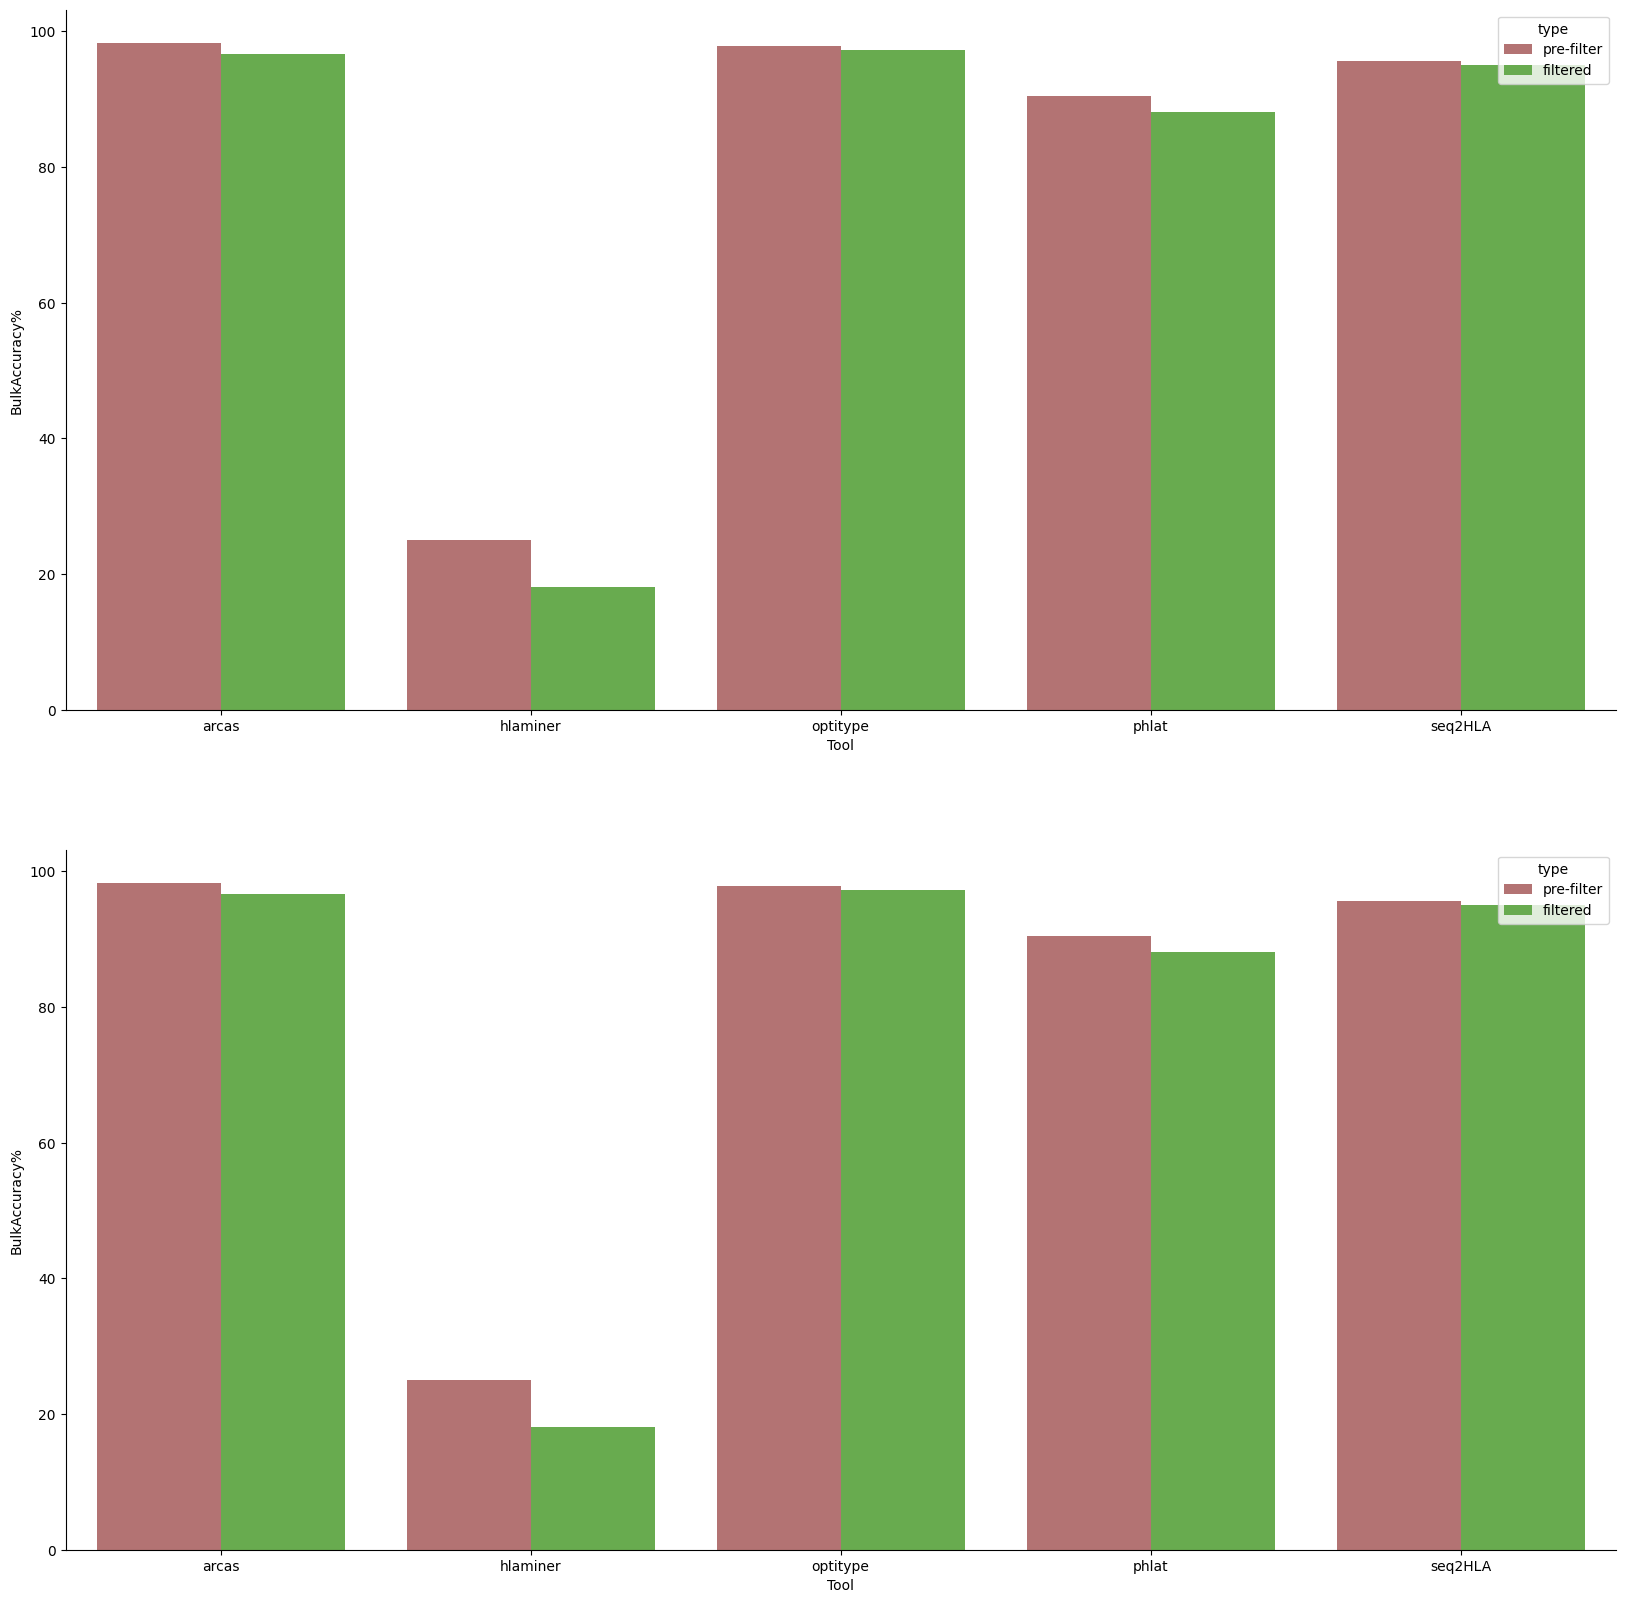

In [ ]:
fig = plt.figure(figsize=(20,20))
#add some p value significance to this 
#left plot
ax=fig.subplots(2,1)
sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy%",ax=ax[0],hue="type",palette=palette)
sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy%",ax=ax[1],hue="type",palette=palette)
#sns.barplot(data=results_2field,x="Tool",y="BulkAccuracy%",ax=ax[0,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field,x="Tool",y="BulkAccuracy%",ax=ax[0,1],hue="Tool",palette=palette)
#sns.barplot(data=results_2field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,1],hue="Tool",palette=palette)
sns.despine()

/var/folders/zf/yd9tbm290zxd2z970lnbp4340000gp/T/ipykernel_93199/3689411694.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy",ax=ax[0],hue="type",palette=palette,log_scale=2)
/var/folders/zf/yd9tbm290zxd2z970lnbp4340000gp/T/ipykernel_93199/3689411694.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy",ax=ax[1],hue="type",palette=palette,log_scale=2)


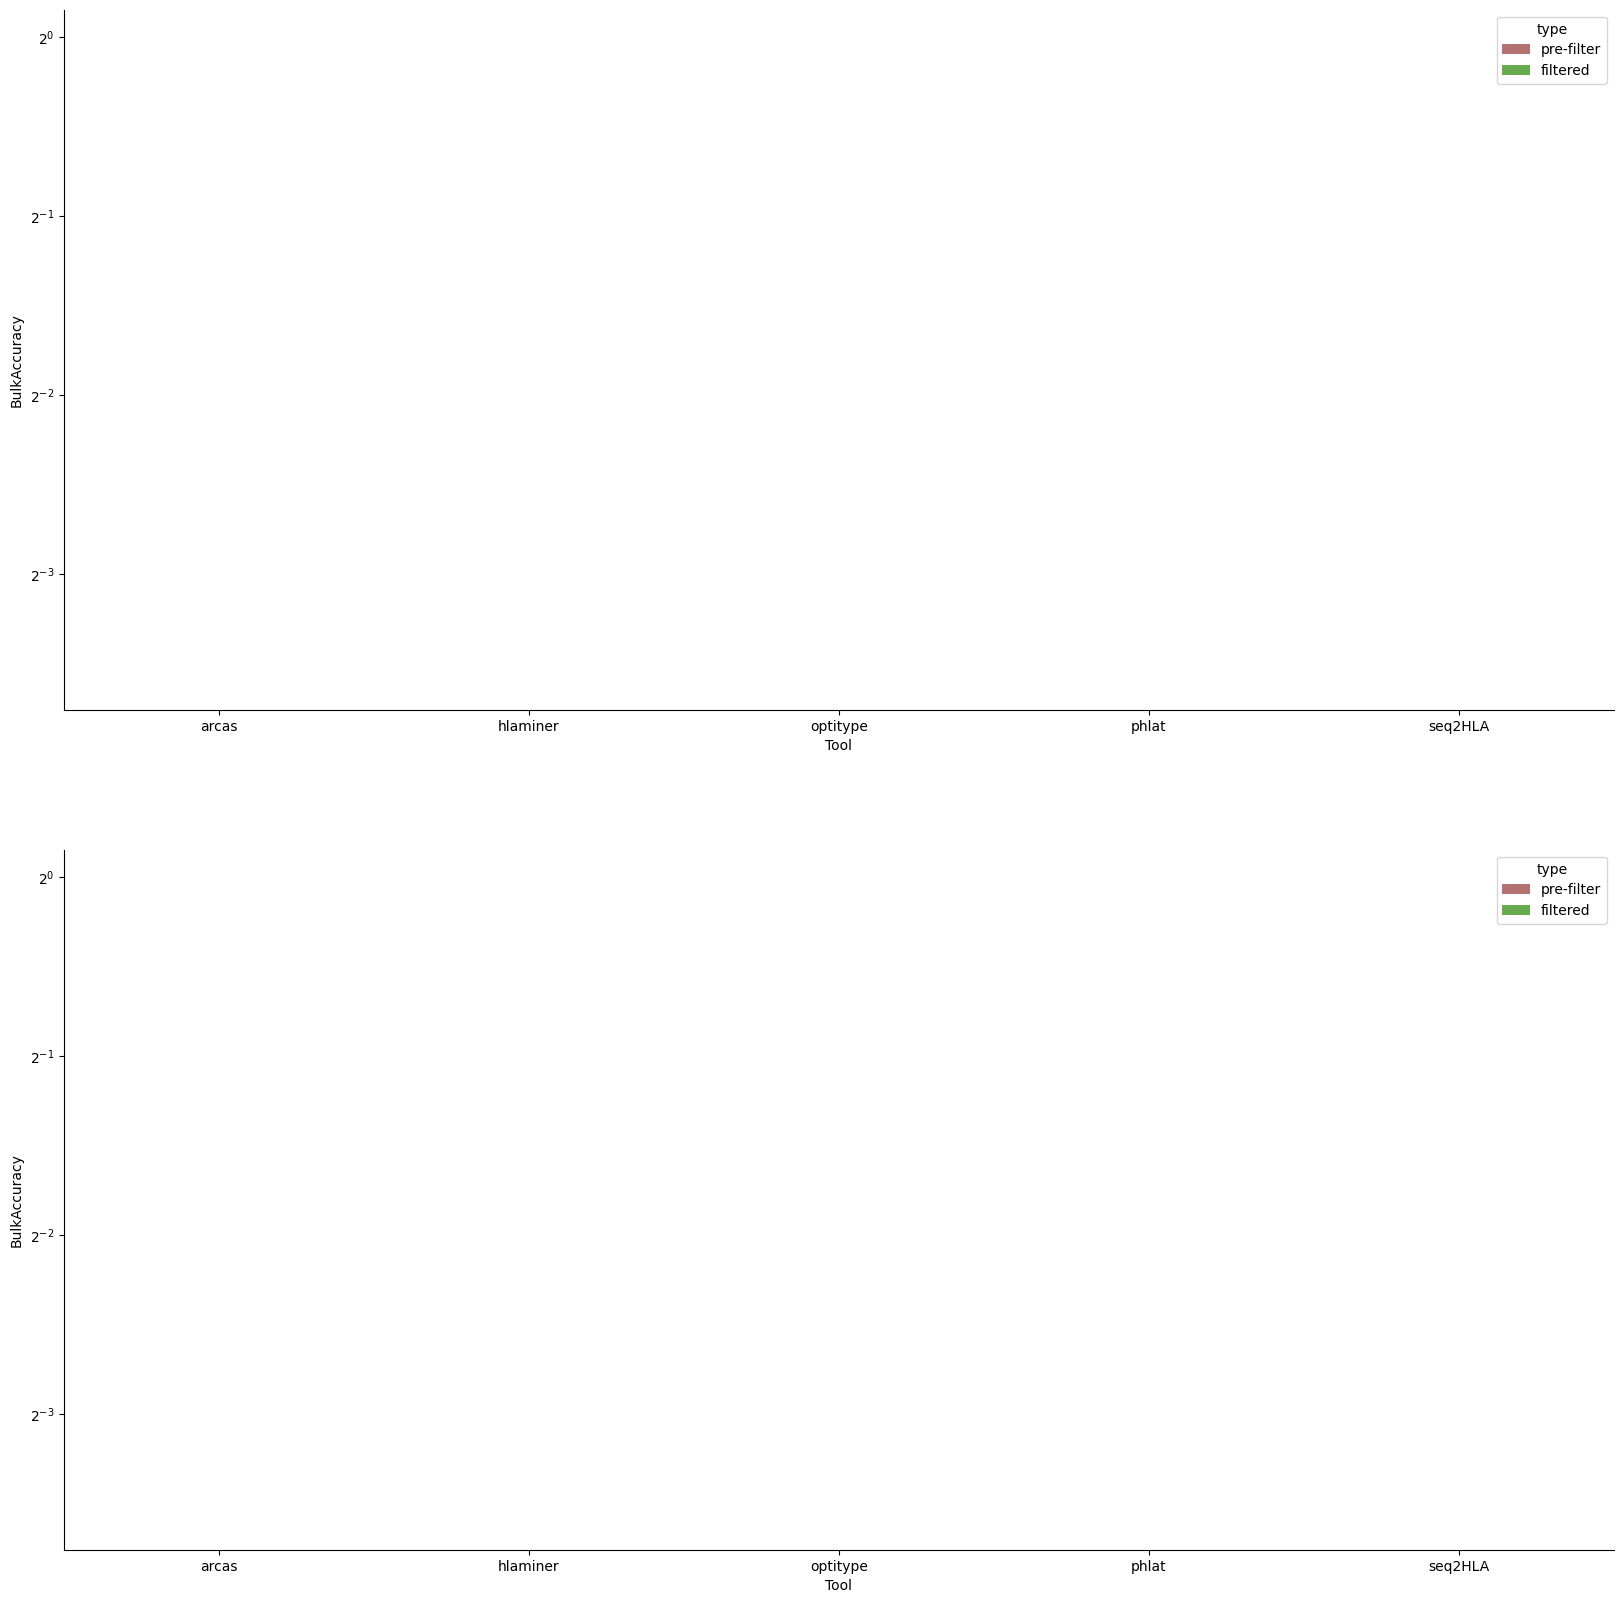

In [139]:
fig = plt.figure(figsize=(20,20))
#add some p value significance to this 
#left plot
ax=fig.subplots(2,1)
sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy",ax=ax[0],hue="type",palette=palette,log_scale=2)
sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy",ax=ax[1],hue="type",palette=palette,log_scale=2)
#sns.barplot(data=results_2field,x="Tool",y="BulkAccuracy%",ax=ax[0,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field,x="Tool",y="BulkAccuracy%",ax=ax[0,1],hue="Tool",palette=palette)
#sns.barplot(data=results_2field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,1],hue="Tool",palette=palette)
sns.despine()

## bulk accuracy by class vertical split

/tmp/ipykernel_4152998/3126729472.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


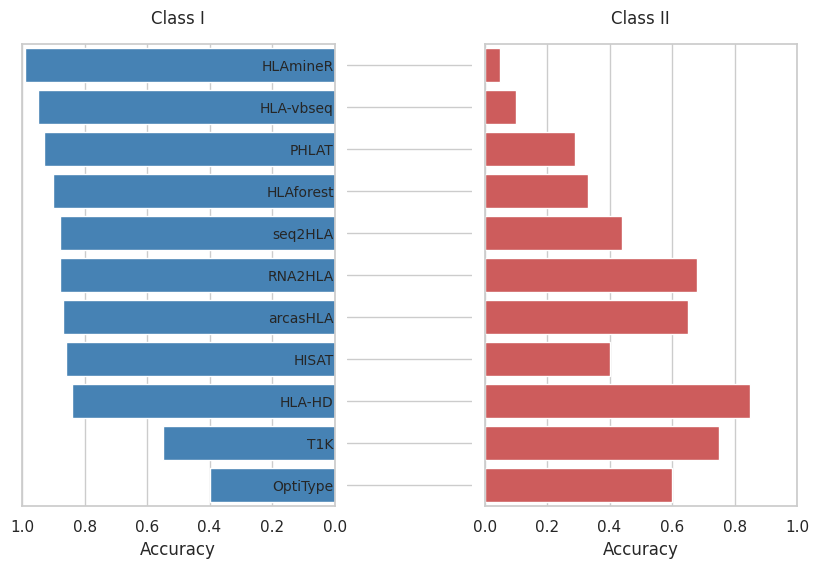

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppose we have a DataFrame df with columns:
#   "Tool", "ClassIAccuracy", "ClassIIAccuracy"
# for demonstration:
data = {
    "Tool": ["OptiType", "T1K", "HLA-HD", "HISAT", "arcasHLA", 
             "RNA2HLA", "seq2HLA", "HLAforest", "PHLAT", "HLA-vbseq", "HLAmineR"],
    "ClassIAccuracy": [0.99, 0.95, 0.93, 0.90, 0.88, 0.88, 0.87, 0.86, 0.84, 0.55, 0.40],
    "ClassIIAccuracy": [0.60, 0.75, 0.85, 0.40, 0.65, 0.68, 0.44, 0.33, 0.29, 0.10, 0.05]
}
df = pd.DataFrame(data)

# 1) Sort the DataFrame by ClassIAccuracy or ClassIIAccuracy as desired
#    so we can plot from highest to lowest. Let's sort by ClassI descending for the example.
df = df.sort_values(by="ClassIAccuracy", ascending=False)

# 2) Prepare figure with three subplots in a single row:
#    left (Class I bars), center (labels), right (Class II bars).
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1, 0.4, 1], wspace=0.05)

ax_left = fig.add_subplot(gs[0, 0])
ax_center = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# The y positions for each tool
y_positions = np.arange(len(df))

# -------------------------------
# Left axis: Class I
# -------------------------------
ax_left.barh(y_positions, df["ClassIAccuracy"], color="steelblue")
ax_left.set_ylim(-0.5, len(df) - 0.5)
ax_left.set_xlim(0, 1)          # If your accuracies are between 0 and 1
ax_left.invert_xaxis()          # So higher accuracy is closer to the label side
ax_left.invert_yaxis()          # So the top row is the first item
ax_left.set_xlabel("Accuracy")
ax_left.set_title("Class I", pad=15)

# Remove y-ticks (we'll use the center axis for labels)
ax_left.set_yticks([])
ax_left.set_yticklabels([])

# -------------------------------
# Center axis: just the labels
# -------------------------------
ax_center.set_xlim(0, 1)        # Arbitrary, minimal horizontal space
ax_center.set_ylim(ax_left.get_ylim())  # Match the same y-limits
ax_center.invert_yaxis()                 # So the top item is at y=0
# Remove spines, ticks, etc., leaving a blank "white" background
for spine in ["top", "bottom", "left", "right"]:
    ax_center.spines[spine].set_visible(False)
ax_center.set_xticks([])
ax_center.set_yticks(y_positions)
ax_center.set_yticklabels(df["Tool"], fontsize=10)
ax_center.tick_params(left=False, labelleft=True, bottom=False, labelbottom=False)

# We won't set x- or y-labels on the center axis
ax_center.set_xlabel("")
ax_center.set_ylabel("")

# -------------------------------
# Right axis: Class II
# -------------------------------
ax_right.barh(y_positions, df["ClassIIAccuracy"], color="indianred")
ax_right.set_ylim(ax_left.get_ylim())  # match
ax_right.invert_yaxis()               # keep the same top-to-bottom order
ax_right.set_xlim(0, 1)
ax_right.set_xlabel("Accuracy")
ax_right.set_title("Class II", pad=15)
# Remove y ticks (labels are in the center axis)
ax_right.set_yticks([])
ax_right.set_yticklabels([])

plt.tight_layout()
plt.show()




## accuracy by locus heatmap

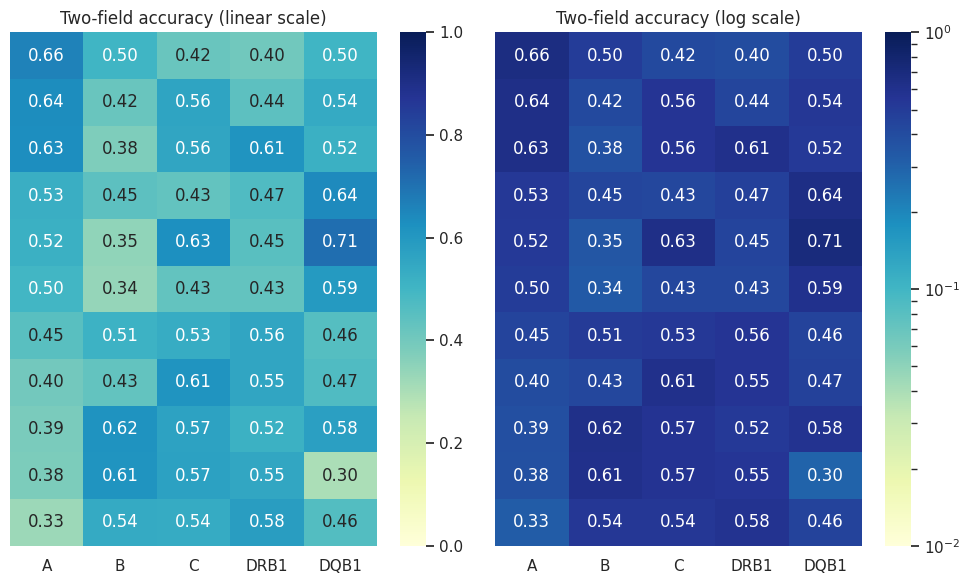

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# -----------------------------------------------------
# 1) Example: Compute Per-Locus Two-Field Accuracy
#    (Using our previously discussed accuracy approach)
# -----------------------------------------------------

# Assume we have an accuracy function, e.g. 'calculate_accuracy_per_locus',
# that returns the two-field accuracy for each tool at each locus for each dataset.
# For example, it might produce a list of dicts with keys: [Tool, Locus, Accuracy].
# You can adapt this snippet to your actual code that calculates per-locus accuracy.

def calculate_accuracy_per_locus(gs_file, pre_file, resolution=2):
    """
    Example function that returns a list of {Tool, Locus, Accuracy} for each locus.
    In practice, you'd adapt the 'calculate_accuracy' logic to track accuracy per locus
    rather than a single global metric. For demonstration, we return dummy data.
    """
    # In reality, you'd parse the gold-standard file, parse the tool predictions,
    # compute accuracy for each locus. Here, we'll just return an example:
    tool_name = pre_file.split("_d")[0]  # e.g. "arcas" if file is "arcas_d1.csv"
    # Suppose we have 5 classical loci: A, B, C, DRB1, DQB1
    loci = ["A", "B", "C", "DRB1", "DQB1"]
    # Just generate random accuracy for demonstration
    import random
    random.seed(hash((gs_file, pre_file)) % 999999)
    results = []
    for locus in loci:
        acc = round(random.uniform(0.0, 1.0), 2)  # random for demonstration
        results.append({
            "Tool": tool_name,
            "Locus": locus,
            "Accuracy": acc
        })
    return results

# Let's say we have multiple tools and multiple datasets:
tools = ["OptiType", "T1K", "HLA-HD", "arcasHLA", "HISAT", "RNA2HLA", 
         "seq2HLA", "PHLAT", "HLAforest", "HLA-vbseq", "HLAmineR"]
datasets = [1, 2, 3, 4, 5, 6, 7, 8]

# We'll store per-locus accuracy in a list
all_rows = []
for tool in tools:
    for ds in datasets:
        gs_file = f"../datasets/{ds}_gs.csv"
        pre_file = f"{tool}_d{ds}.csv"
        # We'll pretend this function returns a list of {Tool, Locus, Accuracy}
        per_locus = calculate_accuracy_per_locus(gs_file, pre_file, resolution=2)
        all_rows.extend(per_locus)

# Now 'all_rows' is a big list of dictionaries
df_per_locus = pd.DataFrame(all_rows)
# df_per_locus should have columns: ["Tool", "Locus", "Accuracy"]

# Next, we want to *aggregate* across all datasets to get a single final
# two-field accuracy per tool-locus. We'll just take the mean across datasets:
df_agg = df_per_locus.groupby(["Tool", "Locus"], as_index=False).agg({"Accuracy": "mean"})

# -----------------------------------------------------
# 2) Pivot so each row is a tool, each column is a locus
# -----------------------------------------------------
df_pivot = df_agg.pivot(index="Tool", columns="Locus", values="Accuracy")

# Suppose we want the columns in the order A, B, C, DRB1, DQB1
df_pivot = df_pivot[["A", "B", "C", "DRB1", "DQB1"]]

# For demonstration, let's fill any missing with 0
df_pivot = df_pivot.fillna(0.0)

# Optionally, sort by one of the columns, e.g. sort by "A" descending
df_pivot = df_pivot.sort_values(by="A", ascending=False)

# -----------------------------------------------------
# 3) Create Two Heatmaps (Side-by-Side)
#    A) Linear scale
#    B) Log scale
# -----------------------------------------------------
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)

# A) Linear scale heatmap
sns.heatmap(
    df_pivot,            # Data
    ax=ax1,
    cmap="YlGnBu",       # colormap
    vmin=0, vmax=1,      # range for [0,1]
    annot=True, fmt=".2f",
    cbar=True
)
ax1.set_title("Two-field accuracy (linear scale)")
ax1.set_xlabel("")  # optional
ax1.set_ylabel("")  # row labels are the tool names
# Keep tool labels horizontal if you prefer:
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# B) Log scale heatmap
import matplotlib.colors as mcolors
norm = mcolors.LogNorm(vmin=1e-2, vmax=1.0)  # adjust min if your lowest > 1e-2
sns.heatmap(
    df_pivot,
    ax=ax2,
    cmap="YlGnBu",
    norm=norm,          # log color scale
    annot=True, fmt=".2f",
    cbar=True
)
ax2.set_title("Two-field accuracy (log scale)")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()
